## Logistic regression

### 1.导入需要的库/模块

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from logistic_regression import LogisticRegression

### 2.加载MNIST数据集

在** ./data/code/transform.c **中，我们对数据集进行了转换和拆分为训练集(training)、验证集(validation)和测试集(testing)

In [3]:
print("Loading training data")
pd_train = pd.read_csv("../data/training", header=None)

print("Loading testing data")
pd_test = pd.read_csv("../data/testing", header=None)

print("Loading validating data")
pd_validate = pd.read_csv("../data/validation", header=None)

Loading training data
Loading testing data
Loading validating data


查看数据集的维度信息：

In [10]:
print(pd_train.shape)
print(pd_test.shape)
print(pd_validate.shape)

(50000, 785)
(10000, 785)
(10000, 785)


我们可以看到训练集有50000个样本，验证集和测试集有10000个样本，每一个样本都是1+28*28=785维的特征向量

### 3.训练模型

MNIST一共类10类(数字0-9)，因此我们需要将Logistic regression推广到多分类问题上。

基本思路：将多分类任务拆若干个二分类任务。学习时分别训练多个分类器，测试时对这个分类器的预测结果进行集成以获得最终的分类结果。

经典的拆分策略有：

- 一对一(OvO)
- 一对多(OvR)
- 多对多(MvM)

我们将使用一对多的拆分方法，每次将一个类的样例作为正例、所有其他类的样例作为反例来训练10个分类器。在测试时选择sigmoid函数值最大的，所对应的类标号作为最终的分类结果。

**baseline:**

In [5]:
PREDICT_NUMBERS = 10

train_X = pd_train.drop([0], axis=1).values / 255.0
predictors = list()
for number in range(0, PREDICT_NUMBERS):
    train_y = np.array(list(map(int, pd_train[0].values == number)))
    predictors.append(LogisticRegression())
    print("------------- Training model for number: %d -------------\n" % number)
    predictors[number].fit(train_X, train_y, 0.5, batch_num=50000, verbose=True)

print("Evaluate model on validating data")
validate_X = pd_validate.drop([0], axis=1).values / 255.
tot_right_num = 0
for tx, ty in zip(validate_X, pd_validate[0].values):
    pred_y = list()
    for number in range(0, PREDICT_NUMBERS):
        pred_y.append(predictors[number].predict(np.reshape(tx, (1, -1))))

    if np.argmax(pred_y) == ty:
        tot_right_num += 1

print("\nOn validating data: %s/%s\n" % (tot_right_num, validate_X.shape[0]))

------------- Training model for number: 0 -------------

step 0: 0.702554
step 10: 0.098281
step 20: 0.079234
step 30: 0.069833
step 40: 0.063964
step 50: 0.059857
step 60: 0.056778
step 70: 0.054360
step 80: 0.052397
step 90: 0.050761
Final training error: 0.049501

------------- Training model for number: 1 -------------

step 0: 0.519057
step 10: 0.083981
step 20: 0.068974
step 30: 0.061465
step 40: 0.056826
step 50: 0.053625
step 60: 0.051261
step 70: 0.049429
step 80: 0.047960
step 90: 0.046750
Final training error: 0.045827

------------- Training model for number: 2 -------------

step 0: 0.718578
step 10: 0.165012
step 20: 0.137207
step 30: 0.123960
step 40: 0.115907
step 50: 0.110379
step 60: 0.106295
step 70: 0.103122
step 80: 0.100566
step 90: 0.098451
Final training error: 0.096830

------------- Training model for number: 3 -------------

step 0: 0.727284
step 10: 0.173113
step 20: 0.148019
step 30: 0.135902
step 40: 0.128520
step 50: 0.123455
step 60: 0.119714
step 70: 0

我们看到该模型在验证集上的准确率有89.6%，这是个不错的结果。

### 4.参数调优

#### 学习率

我们设置7个不同的学习率，各训练一个模型，然后选出在验证集上表现最好的作为最终的学习率：

In [7]:
accuracy_tra = []
accuracy_val = []

for alpha in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]:
    predictors = list()
    print("------------- Training model with alpha %.3f -------------" % alpha)
    for number in range(0, PREDICT_NUMBERS):
        train_y = np.array(list(map(int, pd_train[0].values == number)))
        predictors.append(LogisticRegression())
    #     print("------------- Training model for number: %d -------------\n" % number)
        predictors[number].fit(train_X, train_y, alpha, batch_num=10, verbose=False)

    # print("Evaluate model on validating data")
    tot_right_num_val = 0
    for tx, ty in zip(validate_X, pd_validate[0].values):
        pred_y = list()
        for number in range(0, PREDICT_NUMBERS):
            pred_y.append(predictors[number].predict(np.reshape(tx, (1, -1))))

        if np.argmax(pred_y) == ty:
            tot_right_num_val += 1

    print("On validating data: %s/%s" % (tot_right_num_val, validate_X.shape[0]))
    
    tot_right_num_tra = 0
    for tx, ty in zip(train_X, pd_train[0].values):
        pred_y = list()
        for number in range(0, PREDICT_NUMBERS):
            pred_y.append(predictors[number].predict(np.reshape(tx, (1, -1))))

        if np.argmax(pred_y) == ty:
            tot_right_num_tra += 1

    print("On training data: %s/%s" % (tot_right_num_tra, train_X.shape[0]))
    
    accuracy_tra.append(tot_right_num_tra / 50000)
    accuracy_val.append(tot_right_num_val / 10000)

------------- Training model with alpha 0.001 -------------
On validating data: 9175/10000
On training data: 45497/50000
------------- Training model with alpha 0.003 -------------
On validating data: 9212/10000
On training data: 45878/50000
------------- Training model with alpha 0.010 -------------
On validating data: 9237/10000
On training data: 46144/50000
------------- Training model with alpha 0.030 -------------
On validating data: 9231/10000
On training data: 46245/50000
------------- Training model with alpha 0.100 -------------
On validating data: 9219/10000
On training data: 46120/50000
------------- Training model with alpha 0.300 -------------
On validating data: 9116/10000
On training data: 45576/50000
------------- Training model with alpha 1.000 -------------
On validating data: 8770/10000
On training data: 43720/50000


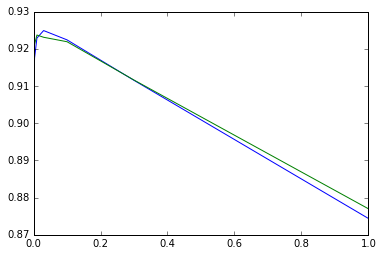

In [14]:
alp = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
plt.plot(alp, accuracy_tra, color="blue", linewidth=1.0, linestyle="-")
plt.plot(alp, accuracy_val, color="green", linewidth=1.0, linestyle="-")

我们可以看到学习率为0.01时，在验证集上的表现最好，让我们以该学习率在训练集上再训练一次：

In [6]:
from time import time

t0 = time()
predictors = list()
for number in range(0, PREDICT_NUMBERS):
    train_y = np.array(list(map(int, pd_train[0].values == number)))
    predictors.append(LogisticRegression())
    print("------------- Training model for number: %d -------------\n" % number)
    predictors[number].fit(train_X, train_y, 0.01, batch_num=10, verbose=True)
    
print('training time %.3fs' % round(time() - t0, 3))

------------- Training model for number: 0 -------------

step 0: 0.049542
step 10: 0.030585
step 20: 0.027832
step 30: 0.026479
step 40: 0.025645
step 50: 0.025066
step 60: 0.024633
step 70: 0.024291
step 80: 0.024010
step 90: 0.023773
Final training error: 0.023587

------------- Training model for number: 1 -------------

step 0: 0.046138
step 10: 0.032117
step 20: 0.029923
step 30: 0.028764
step 40: 0.028000
step 50: 0.027442
step 60: 0.027007
step 70: 0.026653
step 80: 0.026356
step 90: 0.026100
Final training error: 0.025898

------------- Training model for number: 2 -------------

step 0: 0.096797
step 10: 0.073934
step 20: 0.071076
step 30: 0.069663
step 40: 0.068759
step 50: 0.068106
step 60: 0.067601
step 70: 0.067192
step 80: 0.066851
step 90: 0.066561
Final training error: 0.066334

------------- Training model for number: 3 -------------

step 0: 0.112371
step 10: 0.087489
step 20: 0.084005
step 30: 0.082545
step 40: 0.081721
step 50: 0.081171
step 60: 0.080766
step 70: 0

训练时间564s

### 5.测试

最后我们把训练好的模型，用在测试集上，看看准确率如何：

In [21]:
t0 = time()

print("Test model on testing data")
test_X = pd_test.drop([0], axis=1).values / 255.
tot_right_num = 0
for tx, ty in zip(test_X, pd_test[0].values):
    pred_y = list()
    for number in range(0, PREDICT_NUMBERS):
        pred_y.append(predictors[number].predict(np.reshape(tx, (1, -1))))

    if np.argmax(pred_y) == ty:
        tot_right_num += 1

print("\nOn testting data: %s/%s\n" % (tot_right_num, test_X.shape[0]))

print("testting time: %.3fs" % round(time() - t0, 3))

Test model on testing data

On testting data: 9183/10000

testting time: 2.476s


最终我们在测试集上的准确率为91.8%，比起baseline有所提高；在10000个样本上的测试时间为2.48s，这个结果是令人满意。

### 6.持久化

我们把训练好的模型储存起来：

In [23]:
import pickle

with open('logistic_regression.pkl', 'wb') as f:
    pickle.dump(predictors, f)

测试持久化是否成功：

In [25]:
clf = pickle.load(open('logistic_regression.pkl', 'rb'))

print("Test model on testing data")
test_X = pd_test.drop([0], axis=1).values / 255.
tot_right_num = 0
for tx, ty in zip(test_X, pd_test[0].values):
    pred_y = list()
    for number in range(0, PREDICT_NUMBERS):
        pred_y.append(clf[number].predict(np.reshape(tx, (1, -1))))

    if np.argmax(pred_y) == ty:
        tot_right_num += 1

print("\nOn testting data: %s/%s\n" % (tot_right_num, test_X.shape[0]))

Test model on testing data

On testting data: 9183/10000



我们可以发现，从刚才生成的**logistic_regression.pkl**文件中读取的clf一样可以进行预测。

### 7.总结

在项目中，我们用Logistic regression算法实现了一个手写识别系统，最终在测试集上的准确率为91.8%。

学习了：

-  Logistic regression用于多分类问题
- 学习速率的选择
- 使用了pickle进行持久化